In [28]:
import pandas as pd  
import numpy as np 

import matplotlib.pyplot as plt 
import seaborn as sns 

In [29]:
df = pd.read_excel("UK_Data.xlsx")

In [30]:
df.head()

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333828 entries, 0 to 333827
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Unnamed: 0   333828 non-null  int64         
 1   InvoiceNo    333828 non-null  int64         
 2   StockCode    333828 non-null  object        
 3   Description  333828 non-null  object        
 4   Quantity     333828 non-null  int64         
 5   InvoiceDate  333828 non-null  datetime64[ns]
 6   UnitPrice    333828 non-null  float64       
 7   CustomerID   333828 non-null  int64         
 8   Country      333828 non-null  object        
 9   Amount       333828 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 25.5+ MB


### CUSTOMER SEGMENTATION

In [32]:
df['InvoiceDate'] = df['InvoiceDate'].dt.date

In [33]:
ref = df['InvoiceDate'].max()



In [34]:
new = df.loc[df.groupby(df['CustomerID'])['InvoiceDate'].idxmax()][['CustomerID', 'InvoiceDate']]
new['InvoiceDate'] = pd.to_datetime(new['InvoiceDate'])
new.head()

,CustomerID,InvoiceDate
330694,12747,2011-12-07
333774,12748,2011-12-09
327472,12749,2011-12-06
329246,12820,2011-12-06
105304,12821,2011-05-09


In [35]:
new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3818 entries, 330694 to 257930
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   CustomerID   3818 non-null   int64         
 1   InvoiceDate  3818 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 89.5 KB


In [36]:
ref = pd.to_datetime(ref)

In [37]:
new['recency'] = (ref - new['InvoiceDate']).dt.days


In [38]:
new.reset_index(drop = True)

,CustomerID,InvoiceDate,recency
0,12747,2011-12-07,2
1,12748,2011-12-09,0
2,12749,2011-12-06,3
3,12820,2011-12-06,3
4,12821,2011-05-09,214
...,...,...,...
3813,18280,2011-03-07,277
3814,18281,2011-06-12,180
3815,18282,2011-12-02,7
3816,18283,2011-12-06,3


In [39]:
new.head()

,CustomerID,InvoiceDate,recency
330694,12747,2011-12-07,2
333774,12748,2011-12-09,0
327472,12749,2011-12-06,3
329246,12820,2011-12-06,3
105304,12821,2011-05-09,214


> Customer ID 12748 purchased on the reference date, whereas customer ID 12821 had not made any purchase for 214 days.

In [40]:
#For the frequency, we calculate the number of unique invoice per customer

frequency = df.groupby('CustomerID')['InvoiceNo'].nunique()

In [41]:
frequency = frequency.to_frame(name = 'frequency').reset_index()

In [42]:
frequency['frequency']

0        11
1       200
2         5
3         4
4         1
       ... 
3813      1
3814      1
3815      2
3816     16
3817      3
Name: frequency, Length: 3818, dtype: int64

In [43]:
# total amount of spend each customer 

monetary = df.groupby('CustomerID')['Amount'].sum()

In [44]:
monetary.head()

CustomerID
12747     3073.41
12748    24891.45
12749     4032.98
12820      923.62
12821       92.72
Name: Amount, dtype: float64

In [50]:
monetary = monetary.to_frame(name = "monetary").reset_index()

In [45]:
rf = pd.merge(new, frequency, how = "inner", on = "CustomerID")[['CustomerID', 'recency', 'frequency']]

In [46]:
rf

,CustomerID,recency,frequency
0,12747,2,11
1,12748,0,200
2,12749,3,5
3,12820,3,4
4,12821,214,1
...,...,...,...
3813,18280,277,1
3814,18281,180,1
3815,18282,7,2
3816,18283,3,16


In [51]:
rfm = pd.merge(rf, monetary, how = "inner", on = "CustomerID")

In [52]:
rfm.head()

,CustomerID,recency,frequency,monetary
0,12747,2,11,3073.41
1,12748,0,200,24891.45
2,12749,3,5,4032.98
3,12820,3,4,923.62
4,12821,214,1,92.72


In [55]:
quantiles = rfm[['recency', 'frequency', 'monetary']].quantile(q = [0.2, 0.4, 0.6, 0.8])

quantiles

,recency,frequency,monetary
0.2,12.0,1.0,197.766
0.4,32.0,2.0,393.700
0.6,70.0,3.0,734.940
0.8,178.6,5.0,1576.588


In [61]:
def Rscore(x, q, df):
    if x <= df[q][0.2]:
        return 5
    elif x <= df[q][0.4]:
        return 4
    elif x <= df[q][0.6]:
        return 3
    elif x <= df[q][0.8]:
        return 2
    else:
        return 1



In [62]:
rfm_copy = rfm.copy()

rfm_copy['Rscore'] = rfm_copy['recency'].apply(Rscore, args = ('recency', quantiles))

In [64]:
def FMscore(x, q, df):
    if x <= df[q][0.2]:
        return 1
    elif x <= df[q][0.4]:
        return 2
    elif x <= df[q][0.6]:
        return 3
    elif x <= df[q][0.8]:
        return 4
    else:
        return 5


In [65]:
rfm_copy['Fscore'] = rfm_copy['frequency'].apply(FMscore, args = ('frequency', quantiles))

rfm_copy['Mscore'] = rfm_copy['monetary'].apply(FMscore, args = ('monetary', quantiles))

In [68]:
rfm_copy['RFMscore'] = rfm_copy[['Rscore', 'Fscore', 'Mscore']].mean(axis = 1)

rfm_copy.head()

,CustomerID,recency,frequency,monetary,Rscore,Fscore,Mscore,RFMscore
0,12747,2,11,3073.41,5,5,5,5.000000
1,12748,0,200,24891.45,5,5,5,5.000000
2,12749,3,5,4032.98,5,4,5,4.666667
3,12820,3,4,923.62,5,4,4,4.333333
4,12821,214,1,92.72,1,1,1,1.000000


In [69]:
def segment(df):
    if df['RFMscore'] <= 1:
        return 'Basic'
    elif df['RFMscore'] <= 2:
        return 'Bronze'
    elif df['RFMscore'] <= 3:
        return 'Silver'
    elif df['RFMscore'] <= 4:
        return 'Gold'
    elif df['RFMscore'] <= 4.5:
        return 'Platinum'
    else:
        return 'Diamond'

In [70]:
rfm_copy['LoyaltyGroup'] = rfm_copy.apply(segment, axis = 1)
rfm_copy.head()

,CustomerID,recency,frequency,monetary,Rscore,Fscore,Mscore,RFMscore,LoyaltyGroup
0,12747,2,11,3073.41,5,5,5,5.000000,Diamond
1,12748,0,200,24891.45,5,5,5,5.000000,Diamond
2,12749,3,5,4032.98,5,4,5,4.666667,Diamond
3,12820,3,4,923.62,5,4,4,4.333333,Platinum
4,12821,214,1,92.72,1,1,1,1.000000,Basic


### CLUSTERING ALGO 

In [73]:
from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler

In [72]:
rfm.head()

,CustomerID,recency,frequency,monetary
0,12747,2,11,3073.41
1,12748,0,200,24891.45
2,12749,3,5,4032.98
3,12820,3,4,923.62
4,12821,214,1,92.72


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='monetary', ylabel='Count'>

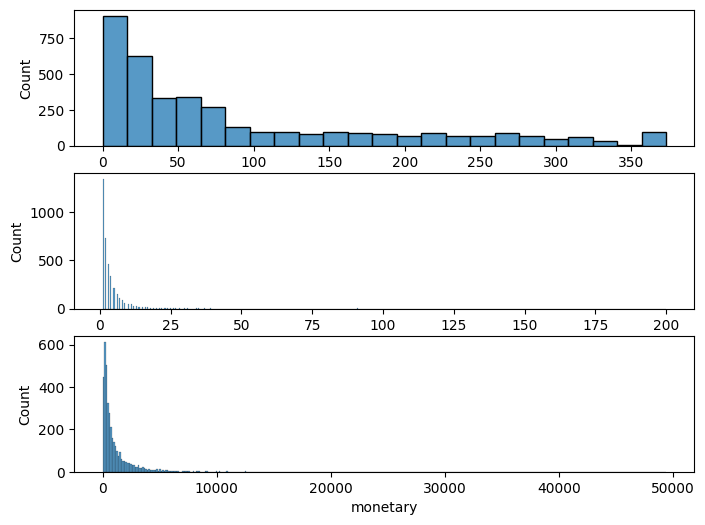

In [75]:
fig, axs = plt.subplots(3, figsize = (8,6))
sns.histplot(rfm['recency'], ax = axs[0])
sns.histplot(rfm['frequency'], ax = axs[1])
sns.histplot(rfm['monetary'], ax = axs[2])


In [76]:
rfm_log = np.log1p(rfm)

In [77]:
scaler = StandardScaler()

rfm_scaled = scaler.fit_transform(rfm_log)

rfm_scaled = pd.DataFrame(data = rfm_scaled,
                          index = rfm.index,
                          columns = rfm.columns)